## Import Library

In [50]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(style="whitegrid")
plt.rcParams['figure.figsize'] = (8, 5)

# display
pd.set_option('display.max_columns', None)
pd.set_option('display.float_format', '{:.2f}'.format)


## Load Dataset

In [51]:
data = pd.read_csv('/home/ooka/BACKUP ARCH/jinx/Belajar/ML Projects/home_credit_default_risk/data/application_train.csv')

## EDA (Explore Data Analysis)

## EDA Step 0

### Show row and column Dataset

Dataset memiliki ~300 ribu baris, yang merepresentasikan jumlah pengajuan pinjaman, dan ratusan fitur yang menggambarkan kondisi finansial dan demografi nasabah.

In [52]:
data.shape

(307511, 122)

### Describe Dataset

In [53]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 307511 entries, 0 to 307510
Columns: 122 entries, SK_ID_CURR to AMT_REQ_CREDIT_BUREAU_YEAR
dtypes: float64(65), int64(41), object(16)
memory usage: 286.2+ MB


### Check Duplicate Dataset

In [55]:
data.duplicated().sum()

np.int64(0)

### Check Unique ID Column

In [56]:
data['SK_ID_CURR'].nunique(), data.shape[0]

(307511, 307511)

### Chech Distribution Target Column

Target sangat tidak seimbang, dengan proporsi default yang jauh lebih kecil dibandingkan non-default. Hal ini mengindikasikan bahwa accuracy bukan metric utama yang tepat.

In [57]:
target_count = data['TARGET'].value_counts()
target_percentage = data['TARGET'].value_counts(normalize=True) * 100

print(target_count)
print(target_percentage)

TARGET
0    282686
1     24825
Name: count, dtype: int64
TARGET
0   91.93
1    8.07
Name: proportion, dtype: float64


### Check Feature Dataset

In [58]:
data.columns

Index(['SK_ID_CURR', 'TARGET', 'NAME_CONTRACT_TYPE', 'CODE_GENDER',
       'FLAG_OWN_CAR', 'FLAG_OWN_REALTY', 'CNT_CHILDREN', 'AMT_INCOME_TOTAL',
       'AMT_CREDIT', 'AMT_ANNUITY',
       ...
       'FLAG_DOCUMENT_18', 'FLAG_DOCUMENT_19', 'FLAG_DOCUMENT_20',
       'FLAG_DOCUMENT_21', 'AMT_REQ_CREDIT_BUREAU_HOUR',
       'AMT_REQ_CREDIT_BUREAU_DAY', 'AMT_REQ_CREDIT_BUREAU_WEEK',
       'AMT_REQ_CREDIT_BUREAU_MON', 'AMT_REQ_CREDIT_BUREAU_QRT',
       'AMT_REQ_CREDIT_BUREAU_YEAR'],
      dtype='object', length=122)

#### EDA 0 Summary :
Dataset application_train.csv terdiri dari X baris dan Y kolom, di mana setiap baris merepresentasikan satu pengajuan pinjaman. 
Tidak ditemukan duplikasi data dan setiap aplikasi memiliki ID unik. Target bersifat imbalanced dengan proporsi default sekitar Z%, 
sehingga evaluasi model perlu mempertimbangkan metric selain accuracy.

## EDA Step 1

### Distribution TARGET Visualization

#### Target Distribution Insight

##### Interpretasi Bisnis
Proporsi nasabah yang mengalami gagal bayar jauh lebih kecil dibandingkan nasabah yang tidak gagal bayar. Hal ini menunjukkan bahwa dataset bersifat imbalanced. Dalam konteks bisnis, kesalahan dalam memprediksi nasabah yang akan gagal bayar (false negative) dapat menyebabkan kerugian finansial yang signifikan, sehingga model harus dioptimalkan untuk mendeteksi kelas minoritas.

##### Simulasi Dampak Bisnis
Dalam konteks kredit, kesalahan klasifikasi memiliki dampak bisnis yang berbeda. False Positive (nasabah berisiko tinggi diprediksi aman) berpotensi menimbulkan kerugian finansial, sementara False Negative (nasabah aman ditolak) berpotensi mengurangi pendapatan. Oleh karena itu, pemilihan threshold dan metric evaluasi akan sangat menentukan strategi bisnis yang diambil.

In [62]:
target_counts = data['TARGET'].value_counts()
target_pct = data['TARGET'].value_counts(normalize=True) * 100

print(target_counts)
print(target_pct)


TARGET
0    282686
1     24825
Name: count, dtype: int64
TARGET
0   91.93
1    8.07
Name: proportion, dtype: float64


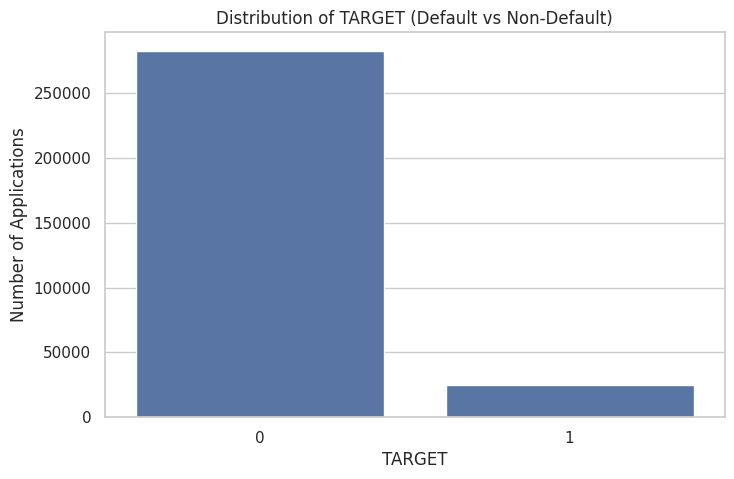

In [64]:
sns.countplot(x='TARGET', data=data)
plt.title('Distribution of TARGET (Default vs Non-Default)')
plt.xlabel('TARGET')
plt.ylabel('Number of Applications')
plt.show()

#### EDA 1 Summary :
Dataset menunjukkan ketidakseimbangan kelas yang signifikan pada variabel target. Kondisi ini menuntut penggunaan metric evaluasi yang lebih tepat seperti ROC-AUC dan Recall. Analisis selanjutnya akan difokuskan pada identifikasi fitur-fitur yang mampu membedakan nasabah berisiko tinggi dan rendah.


## EDA Step 2

### Check and Count Missing Value per Column

In [74]:
missing_count = data.isnull().sum()
missing_pct = missing_count / len(data) * 100

missing_df = pd.DataFrame({
    'missing_count': missing_count,
    'missing_pct': missing_pct
}).sort_values(by='missing_pct', ascending=False)

missing_df.head(20)


,missing_count,missing_pct
COMMONAREA_AVG,214865,69.87
COMMONAREA_MODE,214865,69.87
COMMONAREA_MEDI,214865,69.87
NONLIVINGAPARTMENTS_MEDI,213514,69.43
NONLIVINGAPARTMENTS_MODE,213514,69.43
NONLIVINGAPARTMENTS_AVG,213514,69.43
FONDKAPREMONT_MODE,210295,68.39
LIVINGAPARTMENTS_AVG,210199,68.35
LIVINGAPARTMENTS_MEDI,210199,68.35
LIVINGAPARTMENTS_MODE,210199,68.35


### Missing Value Visualization

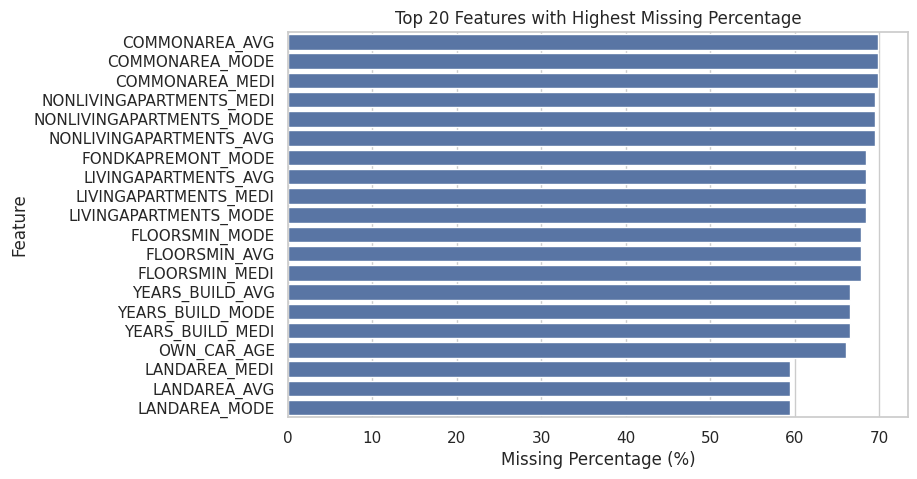

In [76]:
missing_df_head = missing_df[missing_df['missing_pct'] > 0].head(20)

sns.barplot(
    x=missing_df_head['missing_pct'],
    y=missing_df_head.index
)
plt.title('Top 20 Features with Highest Missing Percentage')
plt.xlabel('Missing Percentage (%)')
plt.ylabel('Feature')
plt.show()


### Categorization Missing Value

#### Missing Value Interpretation

Dalam konteks kredit, nilai yang hilang tidak selalu berarti data buruk. Sebaliknya, missing value dapat mengindikasikan bahwa nasabah tidak memiliki produk atau riwayat tertentu (misalnya kartu kredit atau pinjaman sebelumnya). Oleh karena itu, missing value berpotensi menjadi sinyal risiko dan perlu diperlakukan secara hati-hati.

In [77]:
def categorize_missing(pct):
    if pct == 0:
        return 'No Missing'
    elif pct < 10:
        return '<10%'
    elif pct < 30:
        return '10–30%'
    elif pct < 60:
        return '30–60%'
    else:
        return '>60%'

missing_df['missing_category'] = missing_df['missing_pct'].apply(categorize_missing)
missing_df['missing_category'].value_counts()


missing_category
No Missing    55
30–60%        33
>60%          17
<10%          10
10–30%         7
Name: count, dtype: int64

### Show Data

In [93]:
missing_df.head(5)

,missing_count,missing_pct,missing_category
COMMONAREA_AVG,214865,69.87,>60%
COMMONAREA_MODE,214865,69.87,>60%
COMMONAREA_MEDI,214865,69.87,>60%
NONLIVINGAPARTMENTS_MEDI,213514,69.43,>60%
NONLIVINGAPARTMENTS_MODE,213514,69.43,>60%


In [94]:
feature = missing_df.index[10]  # contoh fitur paling banyak missing

df_temp = data[[feature, 'TARGET']].copy()
df_temp['is_missing'] = df_temp[feature].isnull().astype(int)

df_temp.groupby('is_missing')['TARGET'].mean()

is_missing
0   0.07
1   0.09
Name: TARGET, dtype: float64

In [95]:
data['DAYS_BIRTH'].describe()

count   307511.00
mean    -16037.00
std       4363.99
min     -25229.00
25%     -19682.00
50%     -15750.00
75%     -12413.00
max      -7489.00
Name: DAYS_BIRTH, dtype: float64

In [97]:
(data['DAYS_BIRTH'] / -365).describe()

count   307511.00
mean        43.94
std         11.96
min         20.52
25%         34.01
50%         43.15
75%         53.92
max         69.12
Name: DAYS_BIRTH, dtype: float64